In [290]:
#main
import pandas as pd
import numpy as np

#plot
from matplotlib import pyplot as plt
import seaborn as sns

#dop
import re
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display
from datetime import datetime, timedelta, date, time

#prepprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#ML
from sklearn.linear_model import LogisticRegression

#metrics 
from sklearn.metrics import roc_auc_score

# option
pd.set_option("display.max_columns", 300)
plt.rcParams['figure.figsize'] = (15, 10)

PATH_TRAIN = 'data/train.csv'
PATH_TASK = 'data/test.csv'
TARGET_COL = 'target'

In [227]:
time_col = ['time' + str(i) for i in range(1, 11)]

train = pd.read_csv(PATH_TRAIN, parse_dates=time_col, index_col='session_id')
task = pd.read_csv(PATH_TASK, parse_dates=time_col, index_col='session_id')
y_train_full = train[[TARGET_COL]]
df = pd.concat([train.drop(TARGET_COL, axis=1), task], ignore_index=True)

print(train.shape, task.shape)
print('-'*50)
df.info()
df.head()

(253561, 21) (82797, 20)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336358 entries, 0 to 336357
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   336358 non-null  int64         
 1   time1   336358 non-null  datetime64[ns]
 2   site2   331406 non-null  float64       
 3   time2   331406 non-null  datetime64[ns]
 4   site3   326994 non-null  float64       
 5   time3   326994 non-null  datetime64[ns]
 6   site4   323503 non-null  float64       
 7   time4   323503 non-null  datetime64[ns]
 8   site5   320170 non-null  float64       
 9   time5   320170 non-null  datetime64[ns]
 10  site6   317061 non-null  float64       
 11  time6   317061 non-null  datetime64[ns]
 12  site7   314137 non-null  float64       
 13  time7   314137 non-null  datetime64[ns]
 14  site8   311375 non-null  float64       
 15  time8   311375 non-null  datetime64[ns]
 16

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
1,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16
2,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24
3,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42
4,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11


In [30]:
train['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [217]:
def start_in_seconds(x):
    if type(x) != pd._libs.tslibs.nattype.NaTType:
        return pd.to_timedelta(str(x.time())) // np.timedelta64(1, 's')
    else:
        return -1


def feature_engineering(df, time_col):
    df_time = df[time_col].copy()
    
    print('Обработка: weekday')
    df_time['weekday'] = df_time[time_col[0]].progress_apply(lambda x: x.weekday())
    
    for col in time_col:
        print('Обработка: ' + col)
        df_time[col + '_sec'] = df_time[col].progress_apply(start_in_seconds)
    
    print('Обработка: Разницы')
    col_diff = []
    for i in tqdm(range(len(time_col) - 1)):
        df_time[time_col[i + 1]+'-'+time_col[i]] = (df[time_col[i + 1]] - df[time_col[i]]) // np.timedelta64(1, 's')
        col_diff.append(time_col[i + 1]+'-'+time_col[i])
    df_time[col_diff] = df_time[col_diff].fillna(0)
    
    df_time['session_len'] = df_time[col_diff].sum(axis=1)
    df_time['mean_session_len'] = df_time[col_diff].mean(axis=1)
    
    df_time.drop(columns=time_col, axis=1, inplace=True)
    df_time['target'] = df['target']
    return df_time

In [218]:
df_time = feature_engineering(train, time_col)

Обработка: weekday


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time1


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time2


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time3


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time4


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time5


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time6


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time7


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time8


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time9


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time10


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: Разницы


  0%|          | 0/9 [00:00<?, ?it/s]

In [249]:
df_time[df_time['target'] == 1]['weekday'].value_counts()

0    1315
1     526
4     308
3     110
2      38
Name: weekday, dtype: int64

In [236]:
np.timedelta64(30, 'm') // np.timedelta64(1, 's')

1800

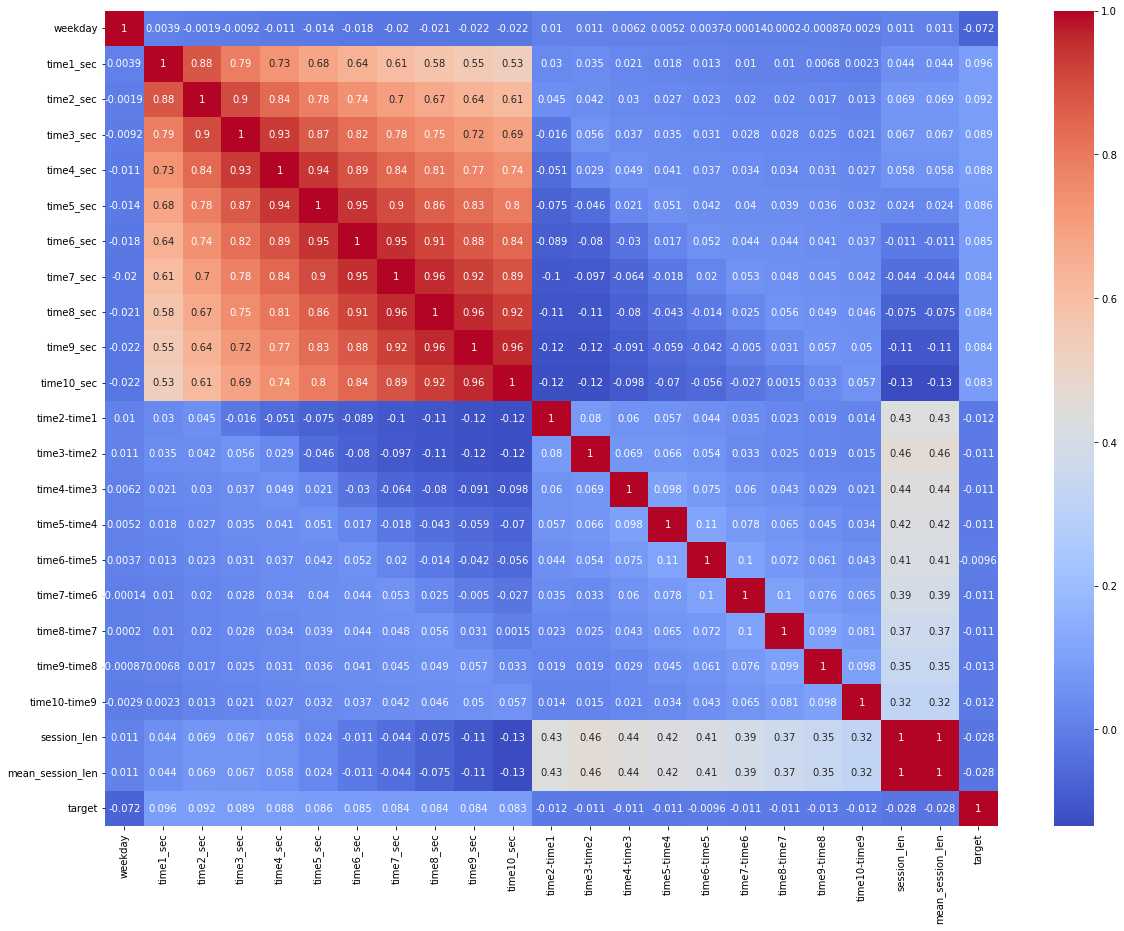

In [257]:
plt.figure(figsize=[20,15])
sns.heatmap(df_time.corr(), annot=True, cmap='coolwarm')
plt.show()

In [263]:
df_time.groupby(by='target').mean()

,weekday,time1_sec,time2_sec,time3_sec,time4_sec,time5_sec,time6_sec,time7_sec,time8_sec,time9_sec,time10_sec,time2-time1,time3-time2,time4-time3,time5-time4,time6-time5,time7-time6,time8-time7,time9-time8,time10-time9,session_len,mean_session_len
target,,,,,,,,,,,,,,,,,,,,,,
0,2.089834,45916.236815,45256.870825,44645.814000,44152.703224,43677.078348,43233.068092,42814.066468,42422.289297,42023.788891,41640.113263,19.050998,19.173499,17.372457,15.240532,14.688411,14.063682,13.457133,13.305440,12.930221,139.282372,15.475819
1,0.942098,57364.195037,57307.452329,57142.976056,57120.966478,56965.327819,56798.353069,56702.550718,56557.993470,56533.623422,56434.548106,6.389639,6.830213,6.437963,5.818024,7.013061,5.908576,5.679582,3.986069,4.233348,52.296474,5.810719


# interim prediction

In [310]:
def get_auc_lr_valid(x, y, C=1.0, seed=17, ratio = 0.9):
    
    ss = StandardScaler()
    x = ss.fit_transform(x)
    # Split the data into the training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - ratio),  random_state=seed)
    
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='lbfgs', max_iter=500).fit(x_train, y_train)
    
    # Prediction for validation set
    y_pred = lr.predict_proba(x_test)[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y_test, y_pred)
    
    return score

In [316]:
df_test = df_time[['weekday', 'time1_sec', 'session_len', 'mean_session_len']]

In [318]:
print(get_auc_lr_valid(df_test, y_train_full))

C:\Users\79214\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8323483331786503


---